<a href="https://colab.research.google.com/github/ljsonnanburg/Classifying-Fake-News/blob/main/Classifying_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

#for text processing
import re, string
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud,STOPWORDS

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition, ensemble
#for word embedding
#import gensim

# to avoid needing to re-run code
import pickle
import os

# for visualizations
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Introduction
False or misleading information being spread either to promote a certain agenda or use sensationalist messaging to sell news media is nothing new. Outright propaganda designed to sway public opinion about how a war is going or whether a public figure is incompetent or some kind of divine incarnation may predate the printing press by more than a thousand years. Tabloid journalism goes back at least as far as 1770, with London publications that effectively collected protection money from socialites and nobility to avoid having gossip printed about them. 

However, more recent advances in technology have led to significantly increased discussion of "fake news"--mass media communication make it easy to spread these messages through various avenues with no or low cost of entry, while social media allows the public to instantly react to or share these stories. If you're on Twitter, Facebook, or another platform, odds are you'll occasionally see intentionally or unintentionally misleading information or linked articles in your feed. It could be on your screen because its attention-grabbing title is driving engagement and promoting its visibility by an algorithm that wants more and more users clicking on more and more things... or it could be because your friend shared it because they found it outraging and didn't have or want to take the free time to vet it for accuracy. 

So, how can we know what to trust when it's so much easier to spread information than it is to verify that it's correct?

# Problem

Given pre-labeled "real" and "fake" news items to train on, can we design a model that accurately predicts whether future articles are true, valuable content or some form of clickbait or propaganda?

There are some brief detours to generate insights from the text data, but the  statistical models compared for text classification use a typical TF-IDF n-gram scoring approach.

# Data Preparation


In [ ]:
# Loading data for true news items
true_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectFN/data/true.csv")
true_news['veracity'] = 'real' # identifying these news items as real
# Loading data for fake news items
fake_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectFN/data/fake.csv")
fake_news['veracity'] = 'fake' # identifying these news items as fake
df = [true_news + fake_news]
df = pd.concat([true_news, fake_news]).reset_index(drop = True) # Vertical concatenation of real/fake news
df['corpus'] = df['title'] + ' ' + df['text'] 
df.sample(10) # Sample of real/fake news items

,title,text,subject,date,veracity,corpus
4695,"Illinois governor vetoes Chicago pension fix, ...",CHICAGO (Reuters) - Illinois Governor Bruce Ra...,politicsNews,"March 24, 2017",real,"Illinois governor vetoes Chicago pension fix, ..."
20131,Austria's leaders reject Juncker's vision for ...,VIENNA (Reuters) - Austria s Social Democrat C...,worldnews,"September 14, 2017",real,Austria's leaders reject Juncker's vision for ...
28826,Rape Kit-Opposing Sheriff Gives Non-Apology F...,"When people think of rape, they generally imag...",News,"March 19, 2016",fake,Rape Kit-Opposing Sheriff Gives Non-Apology F...
9417,"Puerto Rico crisis bill strengthens creditors,...",SAN JUAN (Reuters) - The Congress’ latest atte...,politicsNews,"May 24, 2016",real,"Puerto Rico crisis bill strengthens creditors,..."
36179,IS TRUMP A RACIST? Famous Italian-American “Ge...,Robert Davi gives a great answer to Neil Cavut...,politics,"Dec 22, 2015",fake,IS TRUMP A RACIST? Famous Italian-American “Ge...
28287,Racist North Carolina Hospital Volunteer Lose...,Republicans claim that racism doesn t exist an...,News,"April 16, 2016",fake,Racist North Carolina Hospital Volunteer Lose...
21628,Trump WHINES Like A B*tch On Twitter After NF...,The Democrats and the NFL both told Donald Tru...,News,"October 18, 2017",fake,Trump WHINES Like A B*tch On Twitter After NF...
40807,NO MORE MR. NICE GUY: TRUMP Takes Off The Glov...,Last December a report surfaced that Barack Ob...,left-news,"Dec 28, 2016",fake,NO MORE MR. NICE GUY: TRUMP Takes Off The Glov...
2026,"Trump calls Egypt's Sisi, says keen to overcom...",CAIRO (Reuters) - U.S. President Donald Trump ...,politicsNews,"August 25, 2017",real,"Trump calls Egypt's Sisi, says keen to overcom..."
15832,Macedonia jails 33 ethnic Albanians for 2015 s...,SKOPJE (Reuters) - A Macedonian court sentence...,worldnews,"November 2, 2017",real,Macedonia jails 33 ethnic Albanians for 2015 s...


In [ ]:
df.head()

,title,text,subject,date,veracity,corpus
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",real,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",real,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",real,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",real,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",real,Trump wants Postal Service to charge 'much mor...


In [ ]:
df.shape

(44898, 6)

## Cleaning text

In [ ]:
# Function to begin cleaning up text
stopwords = nltk.corpus.stopwords.words('english')
# Avoids later stemming "U.S." to "u" and taking links to videos as text
replacements = {'U.S.':'united states', '(VIDEO)':'', '[VIDEO]':''}
pattern = re.compile('|'.join(replacements.keys()))

def clean_text(text):
    #text = pattern.sub(lambda m: replacements[re.escape(m.group(0))], text)
    text = text.replace('U.S.', 'united states') # avoids later processing reducing frequent "U.S." from turning into "u"
    # handles
    text = text.replace('[VIDEO]', '')
    text = text.replace('(VIDEO)', '')
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes punctuation
    text = text.lower() # puts all text into lowercase
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [ ]:
clean_df = df.copy()
df['corpus'] = df['corpus'].apply(lambda x:clean_text(x))
df.sample(5)

,title,text,subject,date,veracity,corpus
28662,Florida Continues For-Profit Juvenile Prisons...,The Florida Department of Juvenile Justice has...,News,"March 28, 2016",fake,florida continues forprofit juvenile prisons y...
42861,BREAKING: [VIDEO] Controversial Mayor Who Refu...,There s always another side that s usually bei...,left-news,"Sep 24, 2015",fake,breaking controversial mayor refused allow sha...
44619,FBI Director Comey’s ‘Leaked’ Memo Explains Wh...,21st Century Wire says 21WIRE reported on Frid...,Middle-east,"October 29, 2016",fake,fbi director comey’s ‘leaked’ memo explains he...
43695,EP #9: Patrick Henningsen LIVE – ‘Our Western ...,Join Patrick every Wednesday at Independent Ta...,US_News,"January 12, 2017",fake,ep 9 patrick henningsen live – ‘our western la...
36916,OUCH! HILLARY INTERVIEWER THROWS HILLARY UNDER...,I m shocked! I thought these two were buddies ...,politics,"Jul 7, 2015",fake,ouch hillary interviewer throws hillary scooby...


## Data Exploration and Visualizations

In [ ]:
# Graphs the subjects that show up in each dataframe; there is no overlap in subjects as given
fig = px.histogram(df, x='subject', color='veracity', title='Number of Articles per Subject Matter')
fig.update_layout(barmode='group')
fig.show()

In [ ]:
# Printing unique names from each dataframe to confirm there is no overlap
print(df.loc[df['veracity'] == 'real']['subject'].unique())
print(df.loc[df['veracity'] == 'fake']['subject'].unique())

['politicsNews' 'worldnews']
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


We see that any given subject is entirely sorted into either real or fake news with absolutely no overlap. To compare these in a reasonable way, we would need to rename categories of the "subject" feature to match. Certain steps to this seem obvious: "politicsNews" from true_news likely has overlap with "politics" and possibly "left-news" from fake_news.

...While other steps do not: There is no third category for apolitical local news in true_df; would news about the home government be world news or political news or a third category that still does not exist in true_df?

Since any recategorization would be at least somewhat arbitrary and result in a feature with only two levels, this is ignored to avoid overweighting what could be incorrect guesses.


### Word Cloud for True News Items

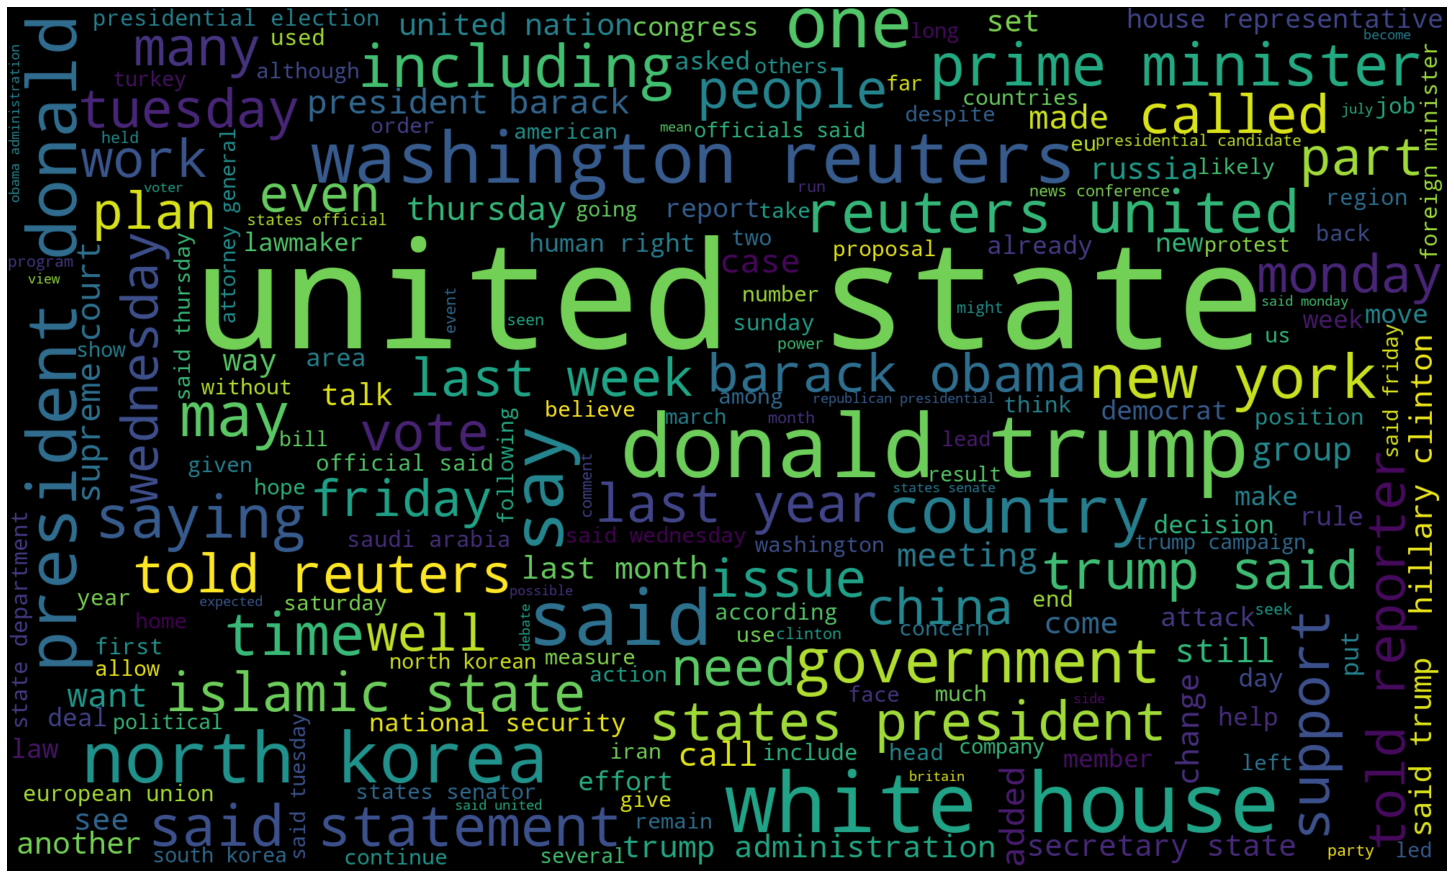

In [ ]:
text = ' '.join(df.loc[df['veracity'] == 'real']['corpus'])
wordcloud = WordCloud(
    width = 2000,
    height = 1200,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
plt.figure(figsize = (20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()




*   The most frequent subjects of true news items appear to be the United States and Donald Trump, suggesting this data set is U.S.-focused
*   Several appearances of Reuters suggest that a lot of true news items come directly from Reuters outlets, or other outlets sourcing Reuters reporting
*   Terms unambiguously specifying the timing of events (e.g., "said wednesday", "last month", "first") appear very frequently in true news items
*   There are few, if any, words with an obvious positive or negative connotation in true news items



### Word Cloud for Fake News Items

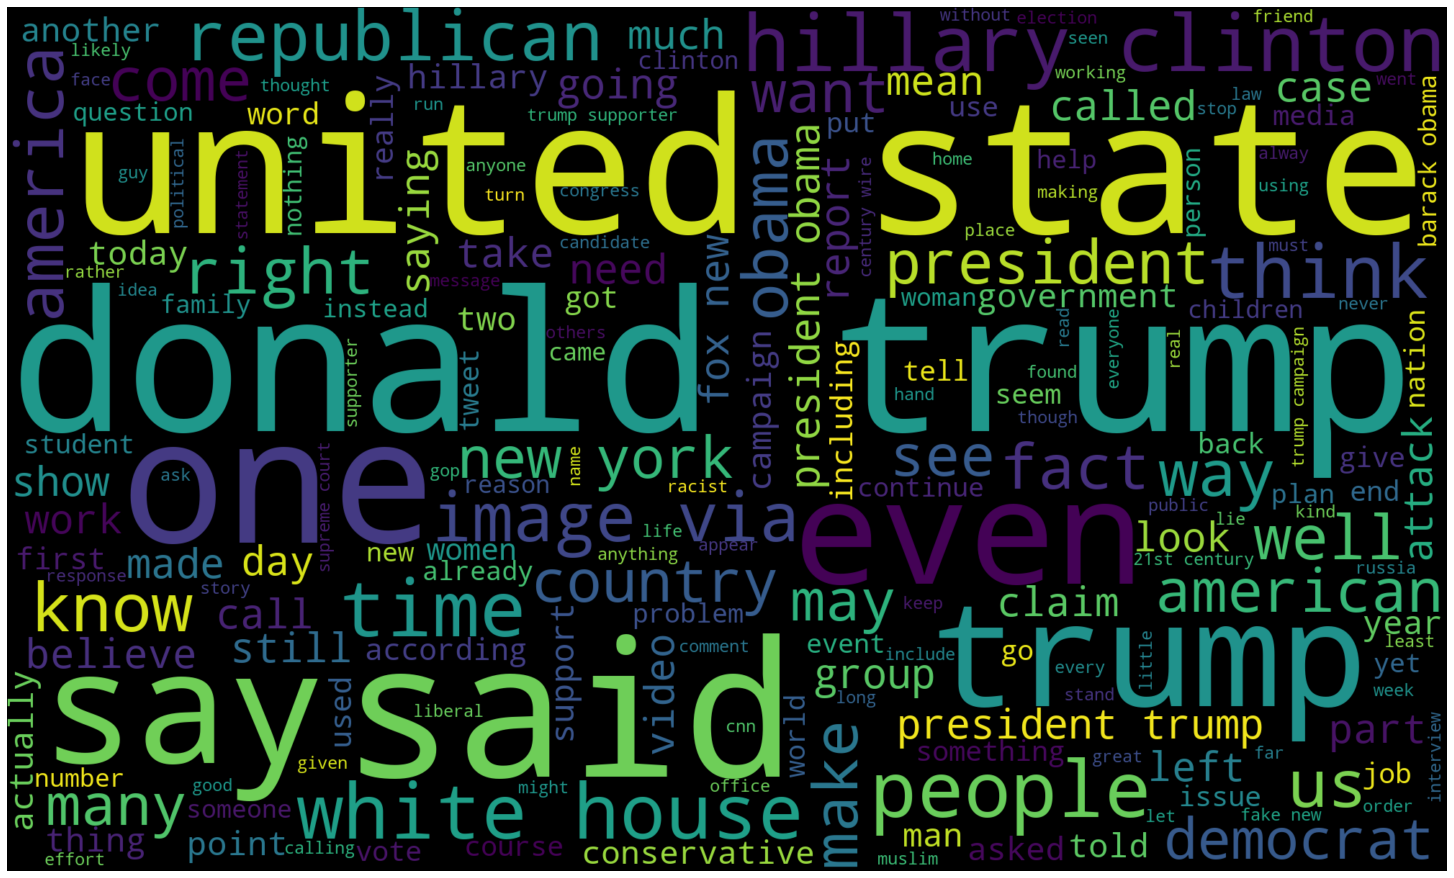

In [ ]:
text = ' '.join(df.loc[df['veracity'] == 'fake']['corpus'])

wordcloud = WordCloud(
    width = 2000,
    height = 1200,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
plt.figure(figsize = (20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


*   Donald Trump and the United States are still the most frequent topics
*   Instances of terms like "supporter", "student", and "person" suggest many of the fake news items might focus on subjects that are not traditionally news-worthy
*   Terms like "according", "tweet", "interview", "comment", "video", and "image via" suggest higher frequency of second-hand reporting
*   Terms with loaded connotations like "lie", "fake", "attack", and "problem" may point to more opinionated writing

### Sensationalist/Clickbait Titles
If we look at the titles of these articles...

In [ ]:
pd.set_option("max_colwidth", 400)
display(df[['title','veracity']].sample(25, random_state=0))
pd.reset_option("max_colwidth")

,title,veracity
35305,RUBIO Sides With Democrats On Giving A Whopping $2 Billion For Zika Virus Prevention,fake
29180,"Ted Cruz Says Endorsing Trump Is A ‘Grave Mistake’, Promises To Do It Anyway (VIDEO)",fake
29805,"‘Responsible Gun Owner’ Road Rages, Threatens To Shoot Motorcyclist (VIDEO)",fake
38237,TEACHER’S UNION PROTEST Gets Ugly As Protesters And Cops Duke It Out [Video],fake
5099,Etihad advises checks with U.S. missions after new Trump order,real
5812,Factbox: Trump U.S. Supreme Court pick could affect pending cases,real
2747,Trump asks Supreme Court to block travel ban ruling,real
34681,BREAKING BOMBSHELL: All Dem Congressmen Phone Numbers And E-mails Hacked…Pelosi PC Hacked,fake
12157,Security tight as Germany marks anniversary of Christmas market attack,real
31537,THIS IS THE ALT-LEFT the Fake News Media Refuses to Tell You About [Video],fake


A few patterns emerge.
*   Fake news items have a lot of vague, attention-grabbing titles that sound outrageous, but convey very little concrete information
*   Promises of a link to a "(VIDEO)" may be common in fake news items
*   Fake news items have A LOT OF WORDS in all-caps, while true ones appear to have none

Intelligent screening for "click-baity" attention grabbing headlines would be a difficult task beyond the scope of this project.

In [ ]:
# Checking if "VIDEO" ever appears in true news items
df[df['title'].str.contains('VIDEO')]['veracity'].unique() 

array(['fake'], dtype=object)

The fact that "VIDEO" only appears in fake news items makes it a very effective predictor of whether an article is true or false. While this isn't useless information, it isn't helpful in categorizing titles that do *not* contain "VIDEO". This is why instances of "[VIDEO]" and "(VIDEO)" were previously omitted from the corpus.


The occurrence of all-caps words, on the other hand, is a time-honored tradition in tabloid journalism and may yield interesting results, here.

In [ ]:
# Function checking for the frequency of words that are in all-caps
def check_all_caps(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.split()
  caps_count = 0
  for word in text:
    if(word == word.upper()):
      caps_count += 1
  return caps_count/len(text)

In [ ]:
df['caps'] = df['title'].apply(check_all_caps)
pd.set_option("max_colwidth", 400)
display(df[['title','veracity','caps']].sample(25))
pd.reset_option("max_colwidth")

,title,veracity,caps
44117,"BOILER ROOM – No Surrender, No Retreat, Heads Will Roll – EP #38",fake,0.461538
3650,Supreme Court tosses Republican-drawn North Carolina voting districts,real,0.000000
5659,"Trump's travel ban has revoked 60,000 visas for now",real,0.111111
24403,Amazon Sells Out Of John Lewis’ Biographies After Trump Attack,fake,0.000000
30523,"CNN’S FAKE NEWS BACKFIRES! CNN Legal Analyst Agrees With Trump On FBI, DOJ: “Off the rails!” [Video]",fake,0.411765
2688,Trump to nominate former Senate aide Peirce for SEC commissioner,real,0.100000
5979,Republican ideas for healthcare reforms could spell trouble for U.S. states,real,0.090909
15173,First lady Melania plays tourist as Trump departs Beijing,real,0.000000
26870,Trump’s Logo Failed So Miserably He Removed All Trace Of It After Only One Day Of Mockery,fake,0.000000
44859,"SHOUT POLL: Will Donald Trump hold his lead, or will he tank?",fake,0.166667


In [ ]:
fig = px.box(df, y='caps', color = 'veracity', title='Box plot showing distribution of fully capitalized words in article titles')
fig.update_layout(barmode='group')
fig.show()

Visually, the difference appears significant, and we will confirm with hypothesis testing. Because we lack knowledge of data beyond this data set, we can play it safe with a quick Student's T-test with the null hypothesis that the mean of all-capitalized words in real and fake news items is roughly the same.

In [ ]:
a = df.loc[df['veracity'] == 'real']['caps']
b = df.loc[df['veracity'] == 'fake']['caps']
stats.ttest_ind(a,b, equal_var=False)

Ttest_indResult(statistic=-132.20099159161254, pvalue=0.0)

With an infinitismal p-value, we can reject the null hypothesis. As expected, there is a statistically significant difference in how much real and fake news items use all-caps text in their titles. However, as with the use of "VIDEO" in titles, these results are incredibly lopsided and easy to interpret. We do not need sophisticated tools for a program (or user) to flag "(VIDEO)" or FULLY CAPITALIZED TITLES as suspicious.

Given that these more experimental detours are something of a dead end, we will only consider the more conventional TF-IDF predictors.

### Stemming
This concludes the exploration I wanted to accomplish with the words intact. Further analysis will rely on simplifying words from the corpus to their root words. 

In [ ]:
try:
  stemmed = pickle.load(open('stemmed.pkl', 'rb'))
except:
  snow_stemmer = SnowballStemmer(language='english')

  stemmed = []
  for i in range(0, len(df)):
      item = df['corpus'][i].split()
      item = [snow_stemmer.stem(word) for word in item]
      item = ' '.join(item)
      stemmed.append(item)   
df['stemmed'] = stemmed

In [ ]:
df[['corpus','stemmed']].head()

,corpus,stemmed
0,united states budget fight looms republicans f...,unit state budget fight loom republican flip f...
1,united states military accept transgender recr...,unit state militari accept transgend recruit m...
2,senior united states republican senator let mr...,senior unit state republican senat let mr muel...
3,fbi russia probe helped australian diplomat ti...,fbi russia probe help australian diplomat tipo...
4,trump wants postal service charge much amazon ...,trump want postal servic charg much amazon shi...


To have 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['veracity','title','text','subject','date'], axis=1), df['veracity'])

# Feature Engineering

### TF-IDF
A TF-IDF score for a given word and article indicates the frequency of that word showing up in that article, relative to how often it shows up in the corpus as a whole. 

The relevance in this study is: if a given term shows up frequently in real articles and not often in the fake articles, its TF-IDF score among real articles will be higher. Then, future articles featuring that term will be considered more likely to be real. Greater concentrations of these real-leaning terms make an article more likely to be classified as real, and the same would be true with fake-leaning terms leading to fake classifications.

In this implementation, the terms being considered are the top 10,000 ngrams made up of between 1 and 4 words. 4 was chosen as an upper bound to potentially capture combinations of the common bigrams from the word clouds.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000,ngram_range=(1,4))

In [ ]:
try:
  X_train_tfidf = pickle.load(open('X_train_tfidf.pkl', 'rb'))
  X_test_tfidf = pickle.load(open('X_test_tfidf.pkl', 'rb'))
except:
  tfidf_vectorizer.fit(df['stemmed'])
  X_train_tfidf =  tfidf_vectorizer.transform(X_train['stemmed'])
  X_test_tfidf =  tfidf_vectorizer.transform(X_test['stemmed'])
  output = open('X_train_tfidf', 'wb')
  pickle.dump(X_train_tfidf, output)
  output = open('X_test_tfidf', 'wb')
  pickle.dump(X_test_tfidf, output)

# Model Building
In order to accurately classify articles, several statistical models are compared. 

The comparison process is to use a pipeline attempting fits and predictions for several models, with a gridsearch function using multiple hyperparameters for each one. The chosen model has the highest accuracy, as there is not a clear impetus for whether it is worse to cast undue skepticism by mislabeling good reporting, or allowing misleading information by mislabeling propaganda.

In [ ]:
try:
  grid = pickle.load(open('grid.pkl', 'rb'))
except: 
  pipe = Pipeline(steps=[('estimator', LinearSVC())])
  params_grid = [{'estimator':[MultinomialNB()],
                'estimator__alpha':[1,.1,.01]
                },
               {'estimator':[RandomForestClassifier()],
                'estimator__max_features':['auto','sqrt','log2'],
                'estimator__bootstrap': [True, False],
                'estimator__n_jobs':[5],
                'estimator__random_state': [0]
                },
               {
                'estimator':[LinearSVC()],
                'estimator__C': [1, 10, 100],
                'estimator__loss': ['hinge', 'squared_hinge'],
                'estimator__max_iter': [10000],
                'estimator__random_state': [0]
                },
               
              ]
  grid = GridSearchCV(pipe, params_grid)
  grid.fit(X_train_tfidf,y_train)
  output = open('grid', 'wb')
  pickle.dump(grid, output)

print(grid.best_params_)
print(grid.best_score_)

{'estimator': RandomForestClassifier(bootstrap=False, n_jobs=5, random_state=0), 'estimator__bootstrap': False, 'estimator__max_features': 'auto', 'estimator__n_jobs': 5, 'estimator__random_state': 0}
0.9977726829842644


The winning model is a random forest classifier, evaluated in more detail below.

In [ ]:
def evaluate_model(clf, y_true, y_pred):
  print(classification_report(y_true, y_pred, target_names=['False','True']))
  cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
  
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax, cmap='RdBu') 

In [ ]:
good_model = RandomForestClassifier(n_jobs=5, bootstrap=True,max_features='auto', max_depth=5)
good_model.fit(X_train_tfidf, y_train)
y_pred=good_model.predict(X_test_tfidf)

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      5882
        True       0.99      0.98      0.98      5343

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



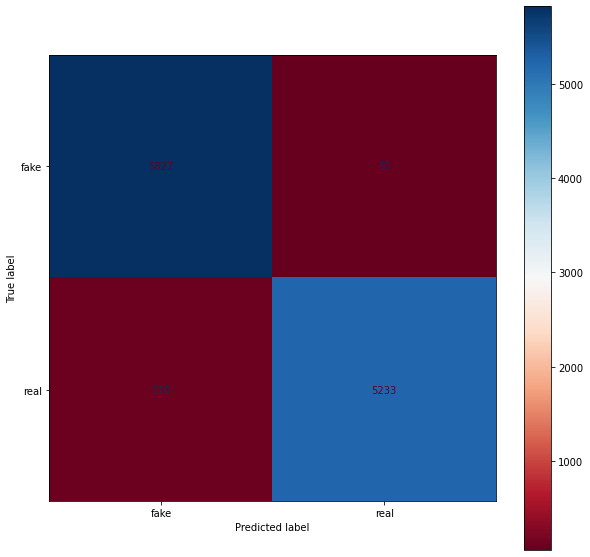

In [ ]:
evaluate_model(good_model, y_test, y_pred)

Below are some of the most influential stemmed terms that have the biggest impact on evaluating a news item as real or fake.

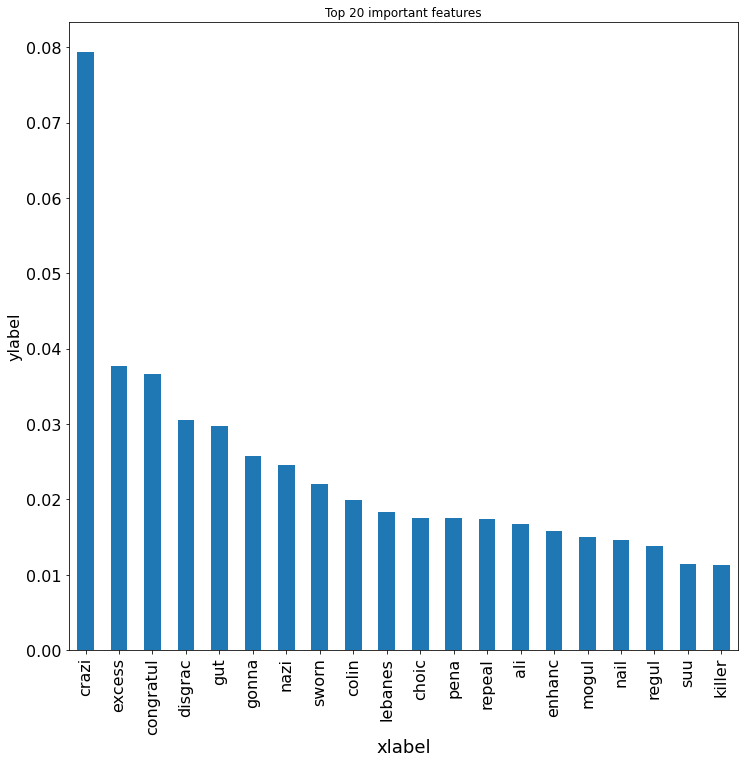

In [ ]:
feat_importances = pd.Series(good_model.feature_importances_, index=tfidf_vectorizer.vocabulary_)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.tight_layout()
plt.rc('axes', titlesize=16) 
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=16)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.show()

While some of this is confusing, some of it is interesting. For brevity, the full text of articles exemplifying these will not be repeated here, so I'll ask that you trust this appraisal:

"Crazi", "disgrac", and "nazi" seem to mostly come from fake-tagged articles littered with insults. 

Names of highly politicized figures in U.S. media (most prominently here Colin kaepernick and Michelle Obama) appear very frequently in fake articles. While "Suu" (Aung San Suu Kyi) is much further removed from U.S. politics and is primarily mentioned in "real"-tagged news articles. 



In [ ]:
y_test_remap = y_test.replace(['fake','real'],[0,1])

y_score = good_model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_remap,y_score)

# Evaluating model performance at various thresholds
roc = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
roc.index.name = "Thresholds"
roc.columns.name = "Rate"

import plotly.graph_objects as go

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

# Conclusion
Further improvements likely could be made--frankly, capping the random forest model at a maximum depth of 5 was a somewhat arbitrary decision to limit potentialy overfitting. However, an F1-score of .97 and ROC curve AUC of .9986 is already fairly ideal.

The real shortcomings of this investigation stem not from the models, but the data and lacking contextual information. A support vector machine model was able to nearly match these results with no fine-tuning, which suggests this data is surprisingly linearly separable for a large mass of text; in other words, this appears to simply be an easy problem. This data also appears to come primarily or perhaps entirely from web-based U.S. publications. These findings might not generalize to more global news outlets. Also, a supervised learning approach to classifying dishonesty will always have the inherent flaw of needing to trust whatever source assigned the labels we train a model on.

Still, the model is clearly identifying some definite patterns to be this accurate, and a sample of "fake news" articles do appear to be just that. In this particular dataset, the answer to the question "can we make an effective classifier fo real and fake news?" seems to be a clear, resounding yes. 